thanks to -> https://stackoverflow.com/questions/49558464/shrink-polygon-using-corner-coordinates

(-0.8500000000000001, 6.85, -1.3744678440936948, 11.065450849718747)

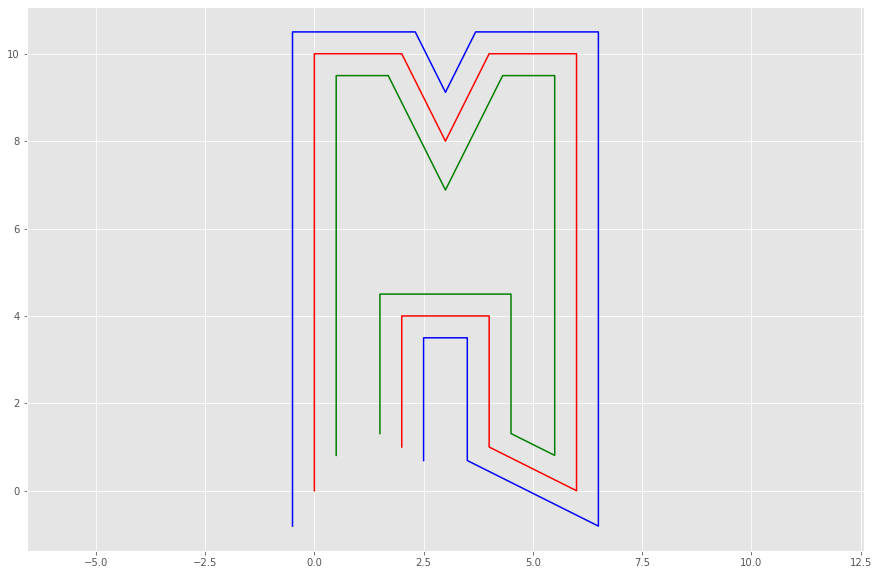

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")

def shrink_polygon(coords, shrink_value_x, shrink_value_y):
    """
    """
    
    def det(a, b):
            return a[0] * b[1] - a[1] * b[0]

    def line_intersection(line1, line2):
        xdiff = (line1[0][0] - line1[1][0], line2[0][0] - line2[1][0])
        ydiff = (line1[0][1] - line1[1][1], line2[0][1] - line2[1][1]) #Typo was here

        div = det(xdiff, ydiff)
        if div == 0:
            raise Exception('lines do not intersect')

        d = (det(*line1), det(*line2))
        x = det(d, xdiff) / div
        y = det(d, ydiff) / div
        return x, y

    # how much the coordinates are moved as an absolute value
    #shrink_value_x = 2
    #shrink_value_y = 2

    # coords must be clockwise
    #coords = [(0, 0), (0, 100), (20, 100), (30, 60), (40, 100), (60, 100), (60, 0), (40, 10), (40, 40), (20, 40), (20, 10)]
    
    lines = [[coords[i-1], coords[i]] for i in range(len(coords))]

    new_lines = []
    for i in lines:
        dx = i[1][0] - i[0][0]
        dy = i[1][1] - i[0][1]

        # this is to take into account slopes
        factor = 1 / (dx*dx + dy*dy)**0.5
        new_dx = dy*shrink_value_x * factor
        new_dy = dx*shrink_value_y * factor

        new_lines.append([(i[0][0] + new_dx, i[0][1] - new_dy),
                          (i[1][0] + new_dx, i[1][1] - new_dy)])

    # find position of intersection of all the lines
    new_coords = []
    for i in range(len(new_lines)):
        new_coords.append((line_intersection(new_lines[i-1], new_lines[i])))
    
    return new_coords

#must be clockwise!
coords = [(0, 0), (0, 10), (2, 10), (3, 8), (4, 10), (6, 10), (6, 0), (4, 1), (4, 4), (2, 4), (2, 1)]

# how much the coordinates are moved as an absolute value
SHIFT = 0.5 #[m]

up =  shrink_polygon(coords, -SHIFT, -SHIFT)
lo =  shrink_polygon(coords, SHIFT, SHIFT)

"""
the last point is out of order for my needs
"""
def rotate(l, n):
    return l[n:] + l[:n]

up = rotate(up,1)
lo = rotate(lo,1)

a = np.array(up)
b = np.array(coords)
c = np.array(lo)

plt.figure(figsize=(15,10))
plt.plot(a[:,0],a[:,1],"b-")
plt.plot(b[:,0],b[:,1],"r-")
plt.plot(c[:,0],c[:,1],"g-")
plt.axis("equal")

now these edges can be used to compute the path as before! Plus outer and inner track

In [2]:
from scipy.interpolate import interp1d
from scipy.signal import savgol_filter
def compute_path_from_wp(start_xp, start_yp, step = 0.1, smooth_factor=7):
    """
    Computes a reference path given a set of waypoints
    """
    
    final_xp=[]
    final_yp=[]
    delta = step #[m]

    for idx in range(len(start_xp)-1):
        section_len = np.sum(np.sqrt(np.power(np.diff(start_xp[idx:idx+2]),2)+np.power(np.diff(start_yp[idx:idx+2]),2)))

        interp_range = np.linspace(0,1,np.floor(section_len/delta).astype(int))
        
        fx=interp1d(np.linspace(0,1,2),start_xp[idx:idx+2],kind=1)
        fy=interp1d(np.linspace(0,1,2),start_yp[idx:idx+2],kind=1)
        
        # watch out to duplicate points!
        final_xp=np.append(final_xp,fx(interp_range)[1:])
        final_yp=np.append(final_yp,fy(interp_range)[1:])
        
    """this smoothens up corners"""
    window_size = smooth_factor # Smoothening filter window
    final_xp = savgol_filter(final_xp, window_size, 1)
    final_yp = savgol_filter(final_yp, window_size, 1)
    
    dx = np.append(0, np.diff(final_xp))
    dy = np.append(0, np.diff(final_yp))
    theta = np.arctan2(dy, dx)

    return np.vstack((final_xp,final_yp,theta))

Text(0.5, 0, 'x')

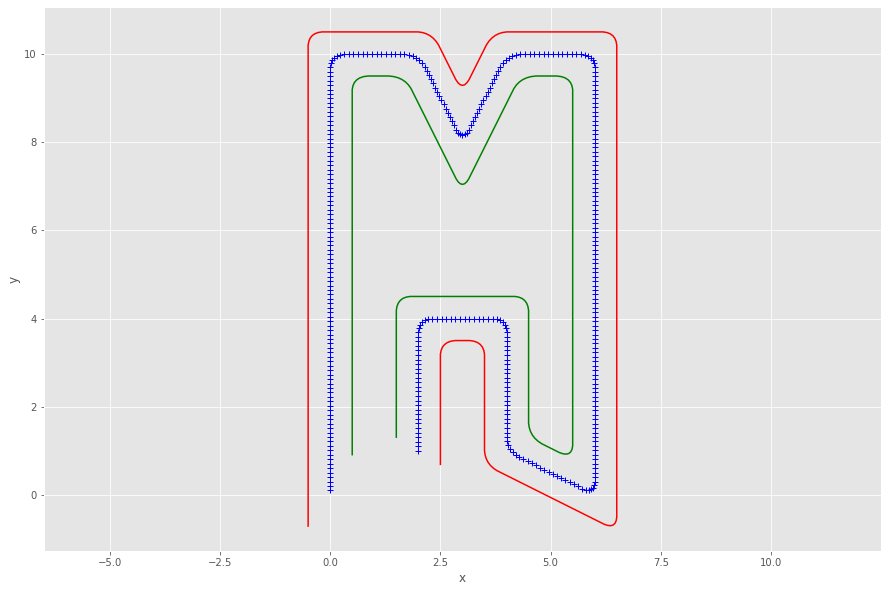

In [3]:
track = compute_path_from_wp(b[:,0],b[:,1])
track_lower = compute_path_from_wp(c[:,0],c[:,1])
track_upper = compute_path_from_wp(a[:,0],a[:,1])

plt.figure(figsize=(15,10))

plt.plot(track[0,:],track[1,:],"b+")
plt.plot(track_lower[0,:],track_lower[1,:],"g-")
plt.plot(track_upper[0,:],track_upper[1,:],"r-")
plt.axis("equal")
plt.ylabel('y')
plt.xlabel('x')

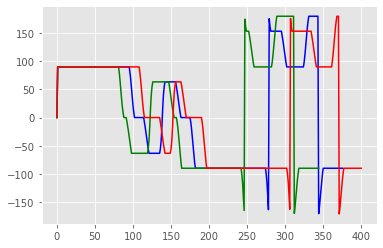

In [4]:
plt.plot(np.degrees(track[2,:]),"b-")
plt.plot(np.degrees(track_lower[2,:]),"g-")
plt.plot(np.degrees(track_upper[2,:]),"r-")

probably smarter to to save this in a file and load it in a notebook, so I dont have to carry over the code...

In [5]:
with open('tracks/test.npy', 'wb') as f:
    np.save(f, track)
    np.save(f, track_lower)
    np.save(f, track_upper)

with open('tracks/test.npy', 'rb') as f:
    a = np.load(f)
    b = np.load(f)
    c = np.load(f)


In [6]:
#matches perfectly!
#plt.plot(np.degrees(a[2,:]),"b-")
#plt.plot(np.degrees(b[2,:]),"g-")
#plt.plot(np.degrees(c[2,:]),"r-")